In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import scipy.io
from scipy.signal import find_peaks, hilbert, cwt, ricker
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import Sequential, callbacks
from tensorflow.keras.layers import GRU, LSTM, Dense, Flatten
from tensorflow.keras.optimizers import Adam
import skill_metrics as sm

In [2]:
def plot_taylor(ref: np.ndarray, predictions_dict: dict,
                central: str, horizon: int):
    """
    Plots Taylor Diagram refering to Reference Serie
    Code by: hrc and jvsg (@cin.ufpe.br)

    Parameters
    ----------
    ref : np.ndarray
        Reference Serie to Taylor Diagram

    predictions_dict : dict
        Dictionary with the predictions you made.
        e.g: {'MLP': np.array([1,2,3,4,5]), 'LSTM': np.array([1,2,3,4,5])}

    central : str
        The name of the dataset

    horizon : int
        The index of horizon

    Returns
    -------
    None

    """
    data = {'preds': [v for k, v in predictions_dict.items()],
            'ref': ref}

    taylor_stats = []
    for pred in data['preds']:
        taylor_stats.append(sm.taylor_statistics(pred, data['ref'], 'data'))

    sdev = np.array([taylor_stats[0]['sdev'][0]]+[x['sdev'][1]
                                                  for x in taylor_stats])
    crmsd = np.array([taylor_stats[0]['crmsd'][0]]+[x['crmsd'][1]
                                                    for x in taylor_stats])
    ccoef = np.array([taylor_stats[0]['ccoef'][0]]+[x['ccoef'][1]
                                                    for x in taylor_stats])

    # To change other params in the plot, check SkillMetrics documentation in
    # https://github.com/PeterRochford/SkillMetrics/wiki/Target-Diagram-Options
    sm.taylor_diagram(sdev, crmsd, ccoef, styleOBS='-',
                      colOBS='g', markerobs='o',
                      titleOBS='Observation',
                      markerLabel=['placeholder']+[
                          k for k, v in predictions_dict.items()])
    plt.show()

In [3]:
def create_models(input_shape: tuple, learning_rate: float,
                  models: list, horizons=12):
    """
    Creates our DNN Models.

    Parameters
    ----------
    input_shape : tuple

    lr : float
        Learning rate

    models : list
        Which models you want to train

    horizons : int
        Number of horizons you want to predict

    Returns
    -------
    list
        DNN Models

    """
    regressors = list()
    if 'MLP' in models:
        regressor = Sequential()
        regressor.add(Flatten(input_shape=input_shape))
        regressor.add(Dense(units=160, activation='relu'))
        regressor.add(Dense(units=180, activation='relu'))
        regressor.add(Dense(units=160, activation='relu'))
        regressor.add(Dense(units=240, activation='relu'))
        regressor.add(Dense(units=horizons))
        regressor.summary()
        Adam(learning_rate=learning_rate)
        regressor.compile(optimizer='adam', loss='mean_squared_error')
        regressors.append(regressor)

    if 'GRU' in models:
        regressor = Sequential()
        regressor.add(GRU(units=160, activation='relu',
                          return_sequences=True, input_shape=input_shape))
        regressor.add(GRU(units=180, activation='relu', return_sequences=True))
        regressor.add(GRU(units=160, activation='relu', return_sequences=True))
        regressor.add(GRU(units=240, activation='relu'))
        regressor.add(Dense(units=horizons))
        regressor.summary()
        regressor.compile(optimizer='adam', loss='mean_squared_error')
        regressors.append(regressor)

    if 'LSTM' in models:
        regressor = Sequential()
        regressor.add(LSTM(units=160, activation='relu',
                           return_sequences=True, input_shape=input_shape))
        regressor.add(LSTM(units=180, activation='relu',
                           return_sequences=True))
        regressor.add(LSTM(units=160, activation='relu',
                           return_sequences=True))
        regressor.add(LSTM(units=240, activation='relu'))
        regressor.add(Dense(units=horizons))
        regressor.summary()
        regressor.compile(optimizer='adam', loss='mean_squared_error')
        regressors.append(regressor)

    return regressors


def get_callbacks(central, model):
    cbs = list()
    checkpoint_path = f"../data/models/{central}/{model}.ckpt"
    cp_callback = callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                            save_weights_only=True,
                                            period=2)
    cbs.append(cp_callback)
    es_callback = callbacks.EarlyStopping(monitor='loss')
    cbs.append(es_callback)
    return cbs

In [4]:
dataset = '../data/inputs/G1.mat'
central = dataset.split('/')[-1].split('.')[0]
matfile = scipy.io.loadmat(dataset)
serie_nan = np.array(matfile['P'], dtype=np.float32)
serie = serie_nan[~np.isnan(serie_nan)]
reg_vars = 3
horizons = 12
models = ['MLP']

In [5]:
train_data = serie[:int(len(serie)*2/3)]
test_data = serie[int(len(serie)*2/3):]
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data.reshape(-1, 1)).squeeze()
test_data = scaler.transform(test_data.reshape(-1, 1)).squeeze()
widths = np.arange(1, 33)
wttrain = cwt(train_data, ricker, widths).transpose()
wttest = cwt(test_data, ricker, widths).transpose()

In [6]:
X_train = list()
X_test = list()
y = list()
for i in range(reg_vars, wttrain.shape[0]-horizons+1):
    obs_y = [serie[i+j] for j in range(horizons)]
    y.append(obs_y)
y_train = np.array(y)
y_train = scaler.transform(y_train)

y = list()
for i in range(reg_vars, wttest.shape[0]-horizons+1):
    obs_y = [serie[wttrain.shape[0]+i+j] for j in range(horizons)]
    y.append(obs_y)
y_test = np.array(y)
y_test = scaler.transform(y_test)

for i in range(reg_vars, wttrain.shape[0]-horizons+1):
    X_train.append(wttrain[i-reg_vars:i])

for i in range(reg_vars, test_data.shape[0]-horizons+1):
    X_test.append(wttest[i-reg_vars:i])

X_train = np.array(X_train)
X_test = np.array(X_test)

In [7]:
regressors = create_models(input_shape=(X_train.shape[1],
                                            X_train.shape[2]),
                               learning_rate=1e-3, models=models,
                               horizons=horizons)
for i, regressor in enumerate(regressors):
    regressor.fit(X_train, y_train, epochs=10, batch_size=32,
                    callbacks=get_callbacks(central, models[i]))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 96)                0         
_________________________________________________________________
dense (Dense)                (None, 160)               15520     
_________________________________________________________________
dense_1 (Dense)              (None, 180)               28980     
_________________________________________________________________
dense_2 (Dense)              (None, 160)               28960     
_________________________________________________________________
dense_3 (Dense)              (None, 240)               38640     
_________________________________________________________________
dense_4 (Dense)              (None, 12)                2892      
Total params: 114,992
Trainable params: 114,992
Non-trainable params: 0
__________________________________________________

In [8]:
preds = [('MLP', regressors[0].predict(X_test))]

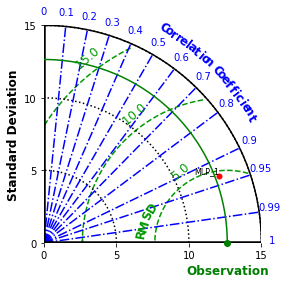

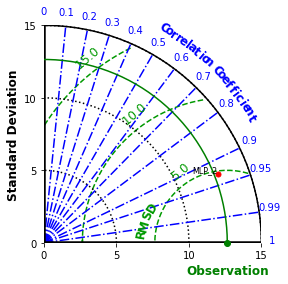

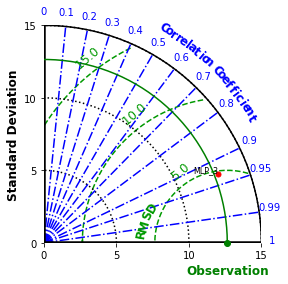

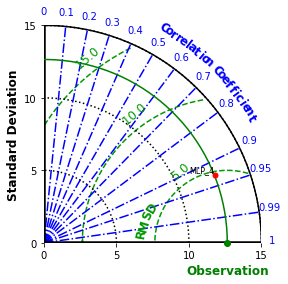

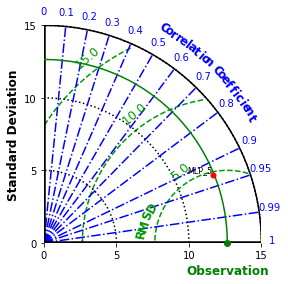

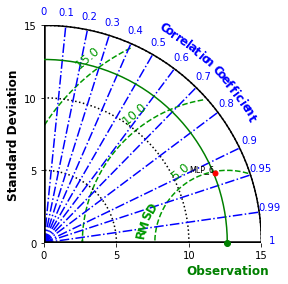

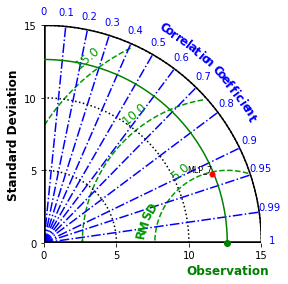

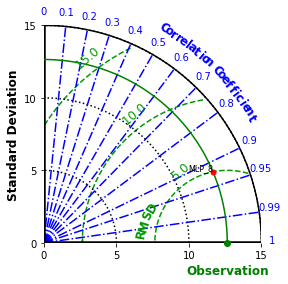

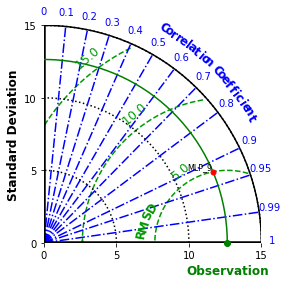

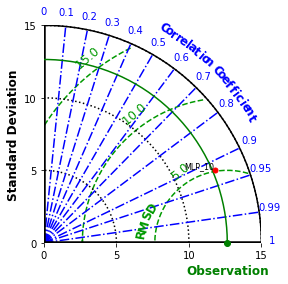

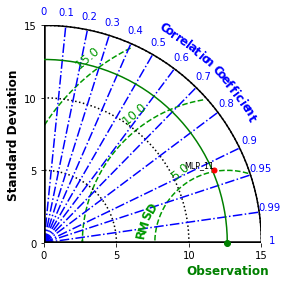

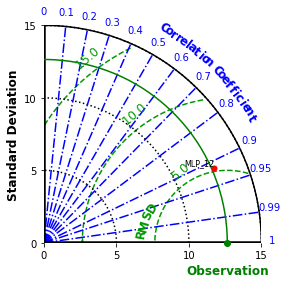

<Figure size 432x288 with 0 Axes>

In [9]:
for i in range(horizons):
    predictions_dict = {}
    for model, y_pred in preds:
        predictions_dict[model +
                            f'_{i+1}'] = y_pred.transpose()[i]/scaler.scale_
    plot_taylor(y_test.transpose()[i] /
                scaler.scale_, predictions_dict, central, i+1)
    plt.clf()